In [1]:
# pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import requests
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler
# from geopy.distance import geodesic
from itertools import combinations
from torch.utils.data import Dataset, DataLoader
from torch_geometric.nn import GATConv
import torch.nn.functional as F

In [3]:
import requests

url = "https://data.cityofnewyork.us/resource/3q43-55fe.json"

params = {
    "$limit": 300000,  # Number of records
    "complaint_type": "Rodent",
    "city": "BROOKLYN"
}

response = requests.get(url, params=params)

if response.status_code == 200:
    data = response.json()

    print(f"Retrieved {len(data)} records.")
else:
    print(f"Failed to retrieve data: {response.status_code}")


Retrieved 96040 records.


In [5]:
complaints_data = pd.DataFrame(data)
complaints_data['created_date'] = pd.to_datetime(complaints_data['created_date'])
complaints_data['zipcode'] = complaints_data['incident_zip'].astype(str)
complaints_data['month'] = complaints_data['created_date'].dt.to_period('M')

In [6]:
rodent_counts = complaints_data.groupby(['zipcode', 'month']).size().reset_index(name='rodent_complaints')

In [7]:
rodent_counts

,zipcode,month,rodent_complaints
0,10458,2011-07,1
1,11201,2010-01,4
2,11201,2010-02,4
3,11201,2010-03,2
4,11201,2010-04,3
...,...,...,...
6643,11385,2024-02,1
6644,11385,2024-10,1
6645,11416,2010-05,2
6646,11426,2018-01,1


In [8]:
params = {
    "$limit": 300000,  # Number of records
    "boro" : "Brooklyn"
}

In [9]:
url_health = "https://data.cityofnewyork.us/resource/43nn-pn8j.json"
response_health = requests.get(url_health, params = params)
health_data = pd.DataFrame(response_health.json())

In [10]:
health_data['score'] = pd.to_numeric(health_data['score'], errors='coerce')
health_data['zipcode'] = health_data['zipcode'].astype(str)
health_data['inspection_date'] = pd.to_datetime(health_data['grade_date'])
health_data['month'] = health_data['inspection_date'].dt.to_period('M')
health_data['key'] = health_data['dba'] + health_data['building']

In [11]:
avg_health_score = health_data.groupby(['zipcode', 'month'])['score'].mean().reset_index()
avg_health_score.rename(columns={'score': 'avg_health_score'}, inplace=True)

# Merge both datasets on ZIP and month
df = pd.merge(rodent_counts, avg_health_score, on=["zipcode", "month"], how="left")

In [13]:
df.drop(columns = ['avg_health_score'], inplace = True)
df = df.sort_values(by=['zipcode', 'month'])

In [15]:
window_size = 3

data_dict = {(row['zipcode'], row['month']): row['rodent_complaints'] for _, row in df.iterrows()}

unique_months = sorted(df['month'].unique())
zipcodes = sorted(df['zipcode'].unique())


training_samples = []


for t in range(window_size, len(unique_months) - 1):
    current_month = unique_months[t]
    next_month = unique_months[t+1]

    x_features = []
    y_targets = []
    available_zipcodes = []

    # Iterate over each zipcode
    for zipcode in zipcodes:
        features = []
        valid = True

        for past_t in range(t - window_size, t):
            month_val = unique_months[past_t]

            if (zipcode, month_val) in data_dict:
                features.append(data_dict[(zipcode, month_val)])
            else:
                valid = False
                break
        if valid and ((zipcode, next_month) in data_dict):
            x_features.append(features)
            y_targets.append(data_dict[(zipcode, next_month)])
            available_zipcodes.append(zipcode)

    # Skip if no zipcode
    if len(x_features) == 0:
        continue

    x_tensor = torch.tensor(x_features, dtype=torch.float)
    y_tensor = torch.tensor(y_targets, dtype=torch.float)

    sample = {
        'x': x_tensor,
        'y': y_tensor,
        'zipcodes': available_zipcodes,
        'current_time': current_month,
        'next_time': next_month
    }
    training_samples.append(sample)

print(f"Created {len(training_samples)} training samples.")

Created 180 training samples.


In [16]:
import torch
from torch_geometric.data import Data

def get_edge_index(zipcodes_list):

    num_nodes = len(zipcodes_list)
    edge_list = []

    # Connect each node to its left and right neighbor in the sorted list
    for i in range(num_nodes):
        if i > 2:
            edge_list.append([i, i - 1])
            edge_list.append([i, i - 2])
            edge_list.append([i, i - 3])
        if i < num_nodes - 3:
            edge_list.append([i, i + 1])
            edge_list.append([i, i + 2])
            edge_list.append([i, i + 3])

    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    return edge_index

sample = training_samples[0]
edge_index = get_edge_index(sample['zipcodes'])


data = Data(x=sample['x'], y=sample['y'], edge_index=edge_index)

print("Edge index tensor:")
print(edge_index)
print("\nGraph Data Object:")
print(data)


Edge index tensor:
tensor([[ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  3,  3,  3,  4,  4,  4,
          4,  4,  4,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,  7,
          7,  7,  7,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9, 10, 10, 10,
         10, 10, 10, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 13, 13, 13,
         13, 13, 13, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 16, 16, 16,
         16, 16, 16, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 19, 19, 19,
         19, 19, 19, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 22, 22, 22,
         22, 22, 22, 23, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 26],
        [ 1,  2,  3,  2,  3,  4,  3,  4,  5,  2,  1,  0,  4,  5,  6,  3,  2,  1,
          5,  6,  7,  4,  3,  2,  6,  7,  8,  5,  4,  3,  7,  8,  9,  6,  5,  4,
          8,  9, 10,  7,  6,  5,  9, 10, 11,  8,  7,  6, 10, 11, 12,  9,  8,  7,
         11, 12, 13, 10,  9,  8, 12, 13, 14, 11, 10,  9, 13, 14, 15, 12, 11, 10,
        

In [18]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4):

        super(GAT, self).__init__()
        # First GAT layer: Outputs concatenated features from multiple heads.
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, concat=True)
        # Second GAT layer: Aggregates information to output a single value per node.
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False)

    def forward(self, x, edge_index):

        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        return x.squeeze()


In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GAT(in_channels=window_size, hidden_channels=4, out_channels=1, heads=2).to(device)

# Define optimizer and number of epochs
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs = 100

model.train()


for epoch in range(num_epochs):
    total_loss = 0.0
    for sample in training_samples:
        # Build graph connectivity
        edge_index = get_edge_index(sample['zipcodes']).to(device)
        x = sample['x'].to(device)
        y = sample['y'].to(device)

        optimizer.zero_grad()

        out = model(x, edge_index)
        # Compute MSE
        loss = F.mse_loss(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(training_samples)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

print("Training finished!")

Epoch 1/100, Loss: 179.3449
Epoch 2/100, Loss: 166.0163
Epoch 3/100, Loss: 164.4837
Epoch 4/100, Loss: 163.3027
Epoch 5/100, Loss: 162.4089
Epoch 6/100, Loss: 161.5123
Epoch 7/100, Loss: 162.2752
Epoch 8/100, Loss: 161.5141
Epoch 9/100, Loss: 160.9098
Epoch 10/100, Loss: 161.0093
Epoch 11/100, Loss: 161.1384
Epoch 12/100, Loss: 161.3964
Epoch 13/100, Loss: 162.0062
Epoch 14/100, Loss: 162.1966
Epoch 15/100, Loss: 162.6452
Epoch 16/100, Loss: 162.2673
Epoch 17/100, Loss: 162.7058
Epoch 18/100, Loss: 162.6383
Epoch 19/100, Loss: 162.6166
Epoch 20/100, Loss: 162.6333
Epoch 21/100, Loss: 162.6704
Epoch 22/100, Loss: 162.7928
Epoch 23/100, Loss: 162.7721
Epoch 24/100, Loss: 162.6838
Epoch 25/100, Loss: 162.5829
Epoch 26/100, Loss: 162.6860
Epoch 27/100, Loss: 162.7718
Epoch 28/100, Loss: 162.7821
Epoch 29/100, Loss: 162.8315
Epoch 30/100, Loss: 162.8451
Epoch 31/100, Loss: 162.6585
Epoch 32/100, Loss: 162.8383
Epoch 33/100, Loss: 162.9410
Epoch 34/100, Loss: 162.8283
Epoch 35/100, Loss: 162

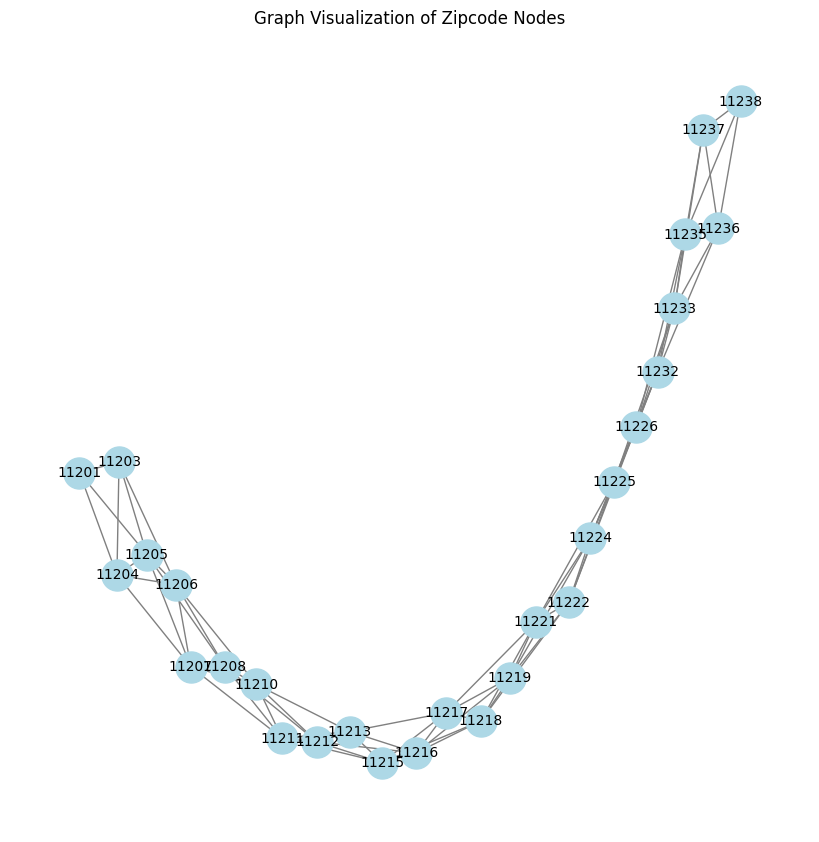

In [20]:
import matplotlib.pyplot as plt
import networkx as nx

def visualize_graph(sample):
    """
    Visualize the graph for a given sample.

    Args:
        sample (dict): A dictionary containing:
           - 'zipcodes': a list of zipcode labels corresponding to nodes
           - node features (not used in this visualization)
    """
    # Build the edge_index using the same helper function
    edge_index = get_edge_index(sample['zipcodes'])

    # Convert edge_index (a torch tensor) to a list of edges
    edge_index_np = edge_index.cpu().numpy() if edge_index.is_cuda else edge_index.numpy()
    # Each column in edge_index_np is an edge [source, target]
    edges = list(zip(edge_index_np[0], edge_index_np[1]))

    # Create an undirected NetworkX graph. For visualization, this is easier to interpret.
    G = nx.Graph()
    # Add nodes with labels using the sample zipcodes
    node_labels = {i: zipcode for i, zipcode in enumerate(sample['zipcodes'])}
    G.add_nodes_from(node_labels.keys())
    G.add_edges_from(edges)
    # Relabel nodes with the zipcode values
    G = nx.relabel_nodes(G, node_labels)

    # Choose a layout; here we use a spring layout for readability.
    pos = nx.spring_layout(G, seed=42)

    # Draw the graph
    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', edge_color='gray', font_size=10)
    plt.title("Graph Visualization of Zipcode Nodes")
    plt.show()

# Example usage:
# Assuming 'training_samples' has been created from the data preparation code.
sample = training_samples[0]
visualize_graph(sample)
